In [25]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')

In [26]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [27]:

my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

def load_user_item_matrix(filepath):
    data = []

    with open(filepath, 'r') as f:
        while True:
            user_line = f.readline()
            if not user_line:
                break

            user_line = user_line.strip()
            if '|' not in user_line:
                continue

            user_id, num_ratings = user_line.split('|')
            user_id = int(user_id)
            num_ratings = int(num_ratings)

            for _ in range(num_ratings):
                item_line = f.readline().strip()
                parts = item_line.split('\t')
                if len(parts) < 2:
                    continue
                item_id, score = parts[0], parts[1]
                data.append([user_id, int(item_id), int(score)])

    df = pd.DataFrame(data, columns=['user_id', 'item_id', 'rating'])
    return df


In [28]:
def safe_int(x):
    return int(x) if x != 'None' else 0


def load_track_data(filepath):
    track_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            track_id = safe_int(parts[0])
            album_id = safe_int(parts[1])
            artist_id = safe_int(parts[2])
            genre_ids = [safe_int(g) for g in parts[3:]] if len(parts) > 3 else []
            track_data.append([track_id, album_id, artist_id, genre_ids])
    return pd.DataFrame(track_data, columns=['track_id', 'album_id', 'artist_id', 'genre_ids'])

def load_album_data(filepath):
    album_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            album_id = safe_int(parts[0])
            artist_id = safe_int(parts[1])
            genre_ids = [safe_int(g) for g in parts[2:]] if len(parts) > 2 else []
            album_data.append([album_id, artist_id, genre_ids])
    return pd.DataFrame(album_data, columns=['album_id', 'artist_id', 'genre_ids'])


# read artistData2
def load_artist_data(filepath):
    with open(filepath, 'r') as f:
        artist_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(artist_ids, columns=['artist_id'])

# read genreData2
def load_genre_data(filepath):
    with open(filepath, 'r') as f:
        genre_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(genre_ids, columns=['genre_id'])

In [29]:
track_df = load_track_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/trackData2.txt')
track_df

,track_id,album_id,artist_id,genre_ids
0,1,106710,281667,"[214765, 162234, 155788]"
1,2,280977,233685,"[131552, 173467, 48505]"
2,3,38422,219136,"[61215, 201738, 88853]"
3,4,119529,166863,"[17453, 35389]"
4,5,16742,294690,"[61215, 34486, 274088]"
...,...,...,...,...
224036,296100,166516,33011,"[274088, 199606, 88853]"
224037,296101,0,0,[]
224038,296102,153644,289056,"[158282, 139095, 242383]"
224039,296105,68336,6613,[82064]


In [30]:
album_df = load_album_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/albumData2.txt')
album_df

,album_id,artist_id,genre_ids
0,0,0,[214765]
1,6,228091,"[158282, 81520, 242383]"
2,19,85028,[103715]
3,30,16832,[31567]
4,33,26330,"[149962, 209270]"
...,...,...,...
52824,296104,125866,[158282]
52825,296106,221637,"[116130, 9432]"
52826,296107,0,[61215]
52827,296108,93277,[61215]


In [31]:
artist_df = load_artist_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/artistData2.txt')
artist_df

,artist_id
0,16
1,23
2,35
3,40
4,49
...,...
18669,295987
18670,296007
18671,296012
18672,296013


In [32]:
genre_df = load_genre_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/genreData2.txt')
genre_df

,genre_id
0,208
1,315
2,642
3,1075
4,1271
...,...
562,292093
563,293670
564,293688
565,294138


In [33]:
train_path = '/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/trainIdx2.txt'
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_df = load_user_item_matrix(train_path)


In [10]:
train_df

,user_id,item_id,rating
0,0,28341,90
1,0,51210,90
2,0,79500,90
3,0,82317,90
4,0,98399,90
...,...,...,...
61944401,249011,270557,90
61944402,249011,273574,90
61944403,249011,286938,90
61944404,249011,287681,80


In [34]:
duplicate_counts = train_df.groupby(['user_id', 'item_id']).size()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"🔁 Number of duplicated (user_id, item_id) pairs: {len(duplicates)}")
print(duplicates.head())


🔁 Number of duplicated (user_id, item_id) pairs: 0
Series([], dtype: int64)


In [12]:
print(train_df['item_id'].max())      # highest item_id
print(track_df['track_id'].max())     # highest track_id
print(train_df['item_id'].isin(track_df['track_id']).mean())  # proportion to match

print(train_df['item_id'].isin(album_df['album_id']).mean())

print(train_df['item_id'].isin(artist_df['artist_id']).mean())

print(train_df['item_id'].isin(genre_df['genre_id']).mean())



296110
296110
0.4385845107627636
0.1925648621120041
0.3114063600835885
0.05744426704164376


In [35]:
def build_item_metadata(track_df, album_df, artist_df, genre_df):
    rows = []

    # 1. Tracks
    for _, row in track_df.iterrows():
        rows.append({
            'item_id': row['track_id'],
            'item_type': 'track',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 2. Albums
    for _, row in album_df.iterrows():
        rows.append({
            'item_id': row['album_id'],
            'item_type': 'album',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 3. Artists
    for artist_id in artist_df['artist_id']:
        rows.append({
            'item_id': artist_id,
            'item_type': 'artist',
            'artist_id': artist_id,
            'genre_ids': 0
        })

    # 4. Genres
    for genre_id in genre_df['genre_id']:
        rows.append({
            'item_id': genre_id,
            'item_type': 'genre',
            'artist_id': 0,
            'genre_ids': [genre_id]
        })

    return pd.DataFrame(rows)

In [36]:
item_meta_df = build_item_metadata(track_df, album_df, artist_df, genre_df)

train_with_meta = train_df.merge(item_meta_df, on='item_id', how='inner')

# When loading the data, sort by a stable column (e.g., user_id)
train_with_meta = train_with_meta.sort_values('user_id').reset_index(drop=True)

train_with_meta

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,0,28341,90,artist,28341,0
1,0,232604,30,artist,232604,0
2,0,237425,50,artist,237425,0
3,0,245257,50,artist,245257,0
4,0,23301,50,artist,23301,0
...,...,...,...,...,...,...
61944401,249011,141075,90,artist,141075,0
61944402,249011,150385,80,genre,0,[150385]
61944403,249011,152077,90,artist,152077,0
61944404,249011,158282,80,genre,0,[158282]


In [37]:
df = train_with_meta.copy()

# Filter: keep only artist & genre (drop album, track)
df = df[~df['item_type'].isin(['album', 'track'])].copy()

print(f"🎯 Sample shape: {df.shape}")
print(f"👤 Users: {df['user_id'].nunique()}, 🎵 Items: {df['item_id'].nunique()}")

🎯 Sample shape: (22848233, 6)
👤 Users: 248344, 🎵 Items: 19241


In [38]:
filtered_df = threshold_interactions_df(df,'user_id','item_id',100,500)

Starting interactions info
Number of rows: 248344
Number of cols: 19241
Sparsity: 0.478%
Ending interactions info
Number of rows: 4644
Number of columns: 8938
Sparsity: 10.674%


In [39]:
# filtered_df = threshold_interactions_df_plus(df, min_items_per_user=500, min_artists_per_user=20, min_genres_per_user=10,min_users_per_item=150)
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
sampled_users = np.random.choice(filtered_df['user_id'].unique(), size=2000, replace=False)
sampled_df = filtered_df[filtered_df['user_id'].isin(sampled_users)]
print(f"🎯 Sample shape: {sampled_df.shape}")
print(f"👤 Users: {sampled_df['user_id'].nunique()}, 🎵 Items: {sampled_df['item_id'].nunique()}")
filtered_df = threshold_interactions_df(sampled_df,'user_id','item_id',100,500)
print(f"🎯 Sample shape: {filtered_df.shape}")

🎯 Sample shape: (1941009, 6)
👤 Users: 2000, 🎵 Items: 8938
Starting interactions info
Number of rows: 2000
Number of cols: 8938
Sparsity: 10.858%
Ending interactions info
Number of rows: 1701
Number of columns: 5011
Sparsity: 17.890%
🎯 Sample shape: (1524894, 6)


Sample shape: (1941009, 6)
👤 Users: 2000, 🎵 Items: 8938
Starting interactions info
Number of rows: 2000
Number of cols: 8938
Sparsity: 10.858%
Ending interactions info
Number of rows: 1701
Number of columns: 5011
Sparsity: 17.890%

In [42]:
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
1039,9,182744,30,artist,182744,0
1040,9,197011,50,artist,197011,0
1041,9,160820,0,artist,160820,0
1043,9,59402,30,artist,59402,0
1044,9,251901,0,artist,251901,0
...,...,...,...,...,...,...
61933948,248947,210727,50,artist,210727,0
61933956,248947,275456,0,artist,275456,0
61933959,248947,203741,0,artist,203741,0
61933965,248947,202602,0,artist,202602,0


In [90]:
# export filtered_df 
filtered_df.to_csv('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/re_sample/filtered_df.csv', index=False)
# Load the filtered DataFrame
filtered_df = pd.read_csv('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/re_sample/filtered_df.csv')

In [91]:
all_user_ids = sorted(filtered_df['user_id'].unique())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

# Example ratios from 10% to 50%
# ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
# splits = {r: split_users_by_ratio(all_user_ids, r) for r in ratios}


## 10% warm

In [92]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.1)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")



In [93]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold


In [94]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")


In [150]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Cold users in X: 1531
Cold items in X: 4793
test users in test: 1473
test items in test: 3890
train users in train: 665
train items in train: 576
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)


Cold users in X: 1531
Cold items in X: 4793
test users in test: 1473
test items in test: 3890
train users in train: 665
train items in train: 576
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)

In [151]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_hybrid.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_hybrid.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_hybrid.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_hybrid.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_hybrid.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_hybrid.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_hybrid.shape}")
print(f"Shape of train_cold: {train_cold_K_hybrid.shape}")
print(f"Shape of X_cold: {X_cold_hybrid.shape}")

Cold users in X: 1531
Cold items in X: 5011
test users in test: 1475
test items in test: 3922
train users in train: 668
train items in train: 567
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)


In [152]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(Tree, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i + 1, min_instances=5)
        pct.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating > 50:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list

## run 10% again

In [153]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_10_new = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 51.9847
MAE:  45.0400
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.0196
MAE:  45.0786
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 47.9907
MAE:  40.7536
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.1414
MAE:  38.7660
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 44.8582
MAE:  37.3751
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 44.2371
MAE:  36.7140
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 43.2880
MAE:  35.6715
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 42.4831
MAE:  34.7866
✅ Iteration 7 complete.


# X with artist only

In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_10 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=5
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.3183
MAE:  45.3803
✅ Baseline evaluation complete.

🔁 Iteration 1/5 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.3011
MAE:  45.3699
✅ Iteration 1 complete.

🔁 Iteration 2/5 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 48.2681
MAE:  41.0345
✅ Iteration 2 complete.

🔁 Iteration 3/5 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.8239
MAE:  39.4838
✅ Iteration 3 complete.

🔁 Iteration 4/5 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 45.4613
MAE:  38.0267
✅ Iteration 4 complete.

🔁 Iteration 5/5 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 44.7911
MAE:  37.2874
✅ Iteration 5 complete.


# X with artist + genre

In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_10 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 51.9772
MAE:  44.9848
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 48.9743
MAE:  41.7818
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.1831
MAE:  38.7730
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 44.9121
MAE:  37.4024
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 43.9624
MAE:  36.3629
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 43.3400
MAE:  35.6949
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 42.2745
MAE:  34.5341
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 41.6559
MAE:  33.8471
✅ Iteration 7 complete.


# Alternative Method

In [44]:
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))



def helf0(matrix, epsilon=1e-10):
    log_U = np.log(matrix.shape[0] + epsilon)  
    
    pop = i_pop(matrix)
    pop_safe = pop + epsilon
    lf = np.log(pop_safe) / log_U

   
    h = i_entropy_0(matrix) / np.log(5)

    numerator = 2 * lf * h
    denominator = lf + h + epsilon
    helf = numerator / denominator

    return helf

def i_variance(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()


In [45]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm,train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 100))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [46]:
entropy0_hybrid = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.1981
MAE:  45.2861
RMSE: 53.2388
MAE:  47.2791
1
RMSE: 53.0280
MAE:  47.0381
2
RMSE: 52.6119
MAE:  46.5845
3
RMSE: 52.3571
MAE:  46.3058
4
RMSE: 52.1265
MAE:  46.0590
5
RMSE: 51.9083
MAE:  45.8077
6
RMSE: 51.4216
MAE:  45.2840
7


In [47]:
entropy0_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.0039
MAE:  45.0624
RMSE: 53.1927
MAE:  47.2321
1
RMSE: 52.7287
MAE:  46.7298
2
RMSE: 52.4058
MAE:  46.3672
3
RMSE: 52.0753
MAE:  46.0166
4
RMSE: 51.5363
MAE:  45.4076
5
RMSE: 51.3048
MAE:  45.1610
6
RMSE: 51.1031
MAE:  44.9212
7


# Max performance

This code snippet creates a combined mapping of user indices to user IDs by merging two separate mappings: idx_to_rid_warm and idx_to_rid_cold. These mappings likely represent two distinct groups of users, such as "warm" users (existing or frequent users) and "cold" users (new or infrequent users). The goal is to ensure that all users are represented in a single unified index space.

The combined_idx_to_rid dictionary is constructed using Python's dictionary unpacking syntax (**). The first part, **idx_to_rid_warm, directly includes all key-value pairs from the idx_to_rid_warm dictionary. This means that the warm user indices are added to the combined mapping without any modification.

The second part, {k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}, processes the idx_to_rid_cold dictionary. Here, a dictionary comprehension is used to offset the keys (indices) of the cold users by the length of the idx_to_rid_warm dictionary. This ensures that the cold user indices do not overlap with the warm user indices. Specifically, for each key-value pair (k, v) in idx_to_rid_cold, the key k is incremented by the number of warm users (len(idx_to_rid_warm)), while the value v (the user ID) remains unchanged.

The resulting combined_idx_to_rid dictionary contains all the warm user indices followed by the offset cold user indices, each mapped to their respective user IDs. This approach ensures that the indices for the two groups are unique and avoids any conflicts when combining the mappings.

In [19]:
def elicitation_max_performance(matrix_warm,train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    warm_copy = matrix_warm.tolil().copy()
    
    # Combine mapping for all users (warm + cold)
    combined_idx_to_rid = {
        **idx_to_rid_warm,
        **{k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}
    }
    full_matrix = sp.vstack([warm_copy, train_copy + X_copy])
    full_df = matrix_to_df_2(full_matrix, combined_idx_to_rid, idx_to_cid)

    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    
    # Performance before elicitation
    reader = Reader(rating_scale=(0,1))
    data_r = Dataset.load_from_df(full_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    print("Baseline performance evaluated.")
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    
    print("Starting elicitation...")
    #scores = strategy(train_copy)
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0

        combined_matrix = sp.vstack([warm_copy, train_copy])
        combined_idx_to_rid = {
            **idx_to_rid_warm,
            **{k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}
        }
        train_df = matrix_to_df_2(combined_matrix, combined_idx_to_rid, idx_to_cid)
        

        reader = Reader(rating_scale=(0,1))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [ ]:
variance_hybrid = elicitation_max_performance(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_variance,
    iteration=40,
    k=1,
    positive=False
)

In [97]:
# Create combined user index mapping
combined_idx_to_rid = {
    **idx_to_rid_warm,  # Original warm user indices
    **{k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}  # Offset cold user indices
}

In [95]:
def elicitation_by_tree_path_max_performance(
    
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    # iteration=5
):

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of warm, cold train and cold X
    cold_KX = train.copy() + X.copy()
    warm_coldKX = sp.vstack([matrix_warm.copy(), cold_KX.copy()])
    warm_coldKX_copy = warm_coldKX.tolil().copy()
    warm_coldKX_df = matrix_to_df_2(warm_coldKX_copy, combined_idx_to_rid, idx_to_cid) # Use combined mapping for KX_df

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 100))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(warm_coldKX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    

       

    return rmse_list, mae_list


In [52]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_artist_10 =elicitation_by_tree_path_max_performance(

    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 53.2705
MAE:  45.7995
✅ Baseline evaluation complete.


In [98]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_hybrid_10 =elicitation_by_tree_path_max_performance(

    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 53.2295
MAE:  45.7663
✅ Baseline evaluation complete.


In [53]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_hybrid_10 =elicitation_by_tree_path_max_performance(

    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 53.2262
MAE:  45.7073
✅ Baseline evaluation complete.


In [88]:
pct_10_artist = [51.9847, 52.0196, 47.9907, 46.1414, 44.8582, 44.2371, 43.2880, 42.4831]

pct_10_hybrid = [51.9772, 48.9743, 46.1831, 44.9121, 43.9624, 43.3400, 42.2745, 41.6559]

entropy_10_hybrid = [52.1981, 53.2388, 53.0280, 52.6119, 52.3571, 52.1265, 51.9083, 51.4216]

entropy_10_artist = [52.0039, 53.1927, 52.7287, 52.4058, 52.0753, 51.5363, 51.3048, 51.1031]



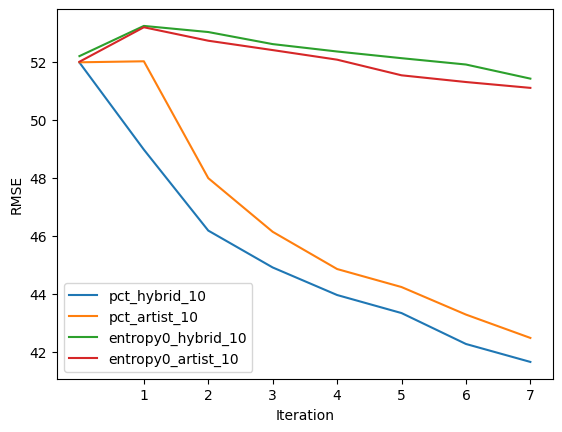

In [76]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_10_hybrid)), pct_10_hybrid, label='pct_hybrid_10')
ax1.plot(np.arange(len(pct_10_artist)), pct_10_artist, label='pct_artist_10')
ax1.plot(np.arange(len(entropy_10_hybrid)), entropy_10_hybrid, label='entropy0_hybrid_10')
ax1.plot(np.arange(len(entropy_10_artist)), entropy_10_artist, label='entropy0_artist_10')

plt.legend(loc=3)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 8)) 
plt.show()

## 20% warm

In [52]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.2)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [53]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [94]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Cold users in X: 1361
Cold items in X: 4793
test users in test: 1321
test items in test: 3821
train users in train: 584
train items in train: 503
-------------------
Shape of test_cold: (1361, 5011)
Shape of train_cold: (1361, 5011)
Shape of X_cold: (1361, 5011)


In [ ]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_hybrid.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_hybrid.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_hybrid.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_hybrid.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_hybrid.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_hybrid.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_hybrid.shape}")
print(f"Shape of train_cold: {train_cold_K_hybrid.shape}")
print(f"Shape of X_cold: {X_cold_hybrid.shape}")

In [58]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_20 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.2930
MAE:  45.1202
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.2144
MAE:  45.0390
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.6760
MAE:  44.4549
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.4298
MAE:  44.1917
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.1970
MAE:  43.9442
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.9571
MAE:  43.6777
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.7175
MAE:  43.4183
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.1466
MAE:  42.8111
✅ Iteration 7 complete.


In [98]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_20 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.3038
MAE:  45.2106
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.2151
MAE:  45.1319
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.6686
MAE:  44.5381
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.3286
MAE:  44.1760
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.0871
MAE:  43.9289
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.8802
MAE:  43.7045
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.6053
MAE:  43.4008
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.9057
MAE:  42.6531
✅ Iteration 7 complete.


In [54]:
entropy0_hybrid_20 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.2918
MAE:  45.2103
RMSE: 53.9341
MAE:  48.1009
1
RMSE: 53.7535
MAE:  47.9182
2
RMSE: 53.5794
MAE:  47.7248
3
RMSE: 52.9201
MAE:  46.9897
4
RMSE: 52.8095
MAE:  46.8646
5
RMSE: 52.5166
MAE:  46.5463
6
RMSE: 52.0293
MAE:  46.0075
7


In [55]:
entropy0_artist_20 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.4771
MAE:  45.3855
RMSE: 54.0693
MAE:  48.2036
1
RMSE: 53.7708
MAE:  47.8589
2
RMSE: 53.6215
MAE:  47.7094
3
RMSE: 53.1566
MAE:  47.1973
4
RMSE: 53.1915
MAE:  47.2178
5
RMSE: 53.0080
MAE:  47.0180
6
RMSE: 52.7476
MAE:  46.7523
7


In [57]:
pct_20_hybrid = [52.3038, 52.2151, 51.6686, 51.3286, 51.0871, 50.8802, 50.6053, 49.9057]

pct_20_artist = [52.2930, 52.2144, 51.6760, 51.4298, 51.1970, 50.9571, 50.7175, 50.1466]

entropy_20_hybrid = [52.2918, 53.9341, 53.7535, 53.5794, 52.9201, 52.8095, 52.5166, 52.0293]

entropy_20_artist = [52.4771, 54.0693, 53.7708, 53.6215, 53.1566, 53.1915, 53.0080, 52.7476]


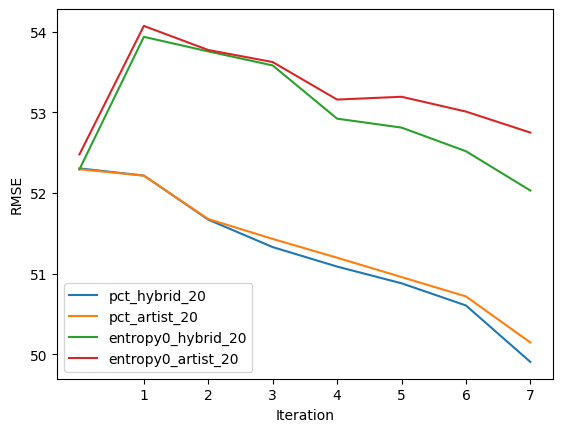

In [77]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_20_hybrid)), pct_20_hybrid, label='pct_hybrid_20')
ax1.plot(np.arange(len(pct_20_artist)), pct_20_artist, label='pct_artist_20')
ax1.plot(np.arange(len(entropy_20_hybrid)), entropy_20_hybrid, label='entropy0_hybrid_20')
ax1.plot(np.arange(len(entropy_20_artist)), entropy_20_artist, label='entropy0_artist_20')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=3)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 8)) 
plt.show()

## 30% warm

In [60]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.3)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [61]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [62]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Cold users in X: 1191
Cold items in X: 4793
test users in test: 1150
test items in test: 3646
train users in train: 529
train items in train: 463
-------------------
Shape of test_cold: (1191, 5011)
Shape of train_cold: (1191, 5011)
Shape of X_cold: (1191, 5011)


In [63]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_hybrid.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_hybrid.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_hybrid.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_hybrid.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_hybrid.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_hybrid.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_hybrid.shape}")
print(f"Shape of train_cold: {train_cold_K_hybrid.shape}")
print(f"Shape of X_cold: {X_cold_hybrid.shape}")

Cold users in X: 1191
Cold items in X: 5011
test users in test: 1147
test items in test: 3686
train users in train: 521
train items in train: 448
-------------------
Shape of test_cold: (1191, 5011)
Shape of train_cold: (1191, 5011)
Shape of X_cold: (1191, 5011)


In [107]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_30 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.8811
MAE:  45.4660
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.4017
MAE:  44.9444
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.0626
MAE:  44.6048
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.7871
MAE:  44.3139
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.2051
MAE:  42.6345
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.5147
MAE:  41.8963
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.0861
MAE:  41.4380
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.6354
MAE:  38.8685
✅ Iteration 7 complete.


In [105]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_30 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.3823
MAE:  45.0055
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.8302
MAE:  44.4170
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.5232
MAE:  44.0817
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.2696
MAE:  43.8128
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.5404
MAE:  43.0413
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.9093
MAE:  42.3704
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.8529
MAE:  39.1618
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.0297
MAE:  38.2920
✅ Iteration 7 complete.


In [64]:
entropy0_hybrid_30 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.3960
MAE:  45.0198
RMSE: 54.3612
MAE:  48.5150
1
RMSE: 54.2035
MAE:  48.3356
2
RMSE: 53.9256
MAE:  48.0354
3
RMSE: 53.8412
MAE:  47.9613
4
RMSE: 53.6288
MAE:  47.7133
5
RMSE: 53.2585
MAE:  47.2895
6
RMSE: 52.9956
MAE:  47.0137
7


In [65]:
entropy0_artist_30 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.8983
MAE:  45.4909
RMSE: 54.8613
MAE:  49.0332
1
RMSE: 54.6676
MAE:  48.8195
2
RMSE: 54.4906
MAE:  48.6298
3
RMSE: 54.1528
MAE:  48.2423
4
RMSE: 54.0773
MAE:  48.1750
5
RMSE: 53.8051
MAE:  47.8680
6
RMSE: 53.6204
MAE:  47.6666
7


In [69]:
pct_30_artist = [52.8811, 52.4017, 52.0626, 51.7871, 50.2051, 49.5147, 49.0861, 46.6354]
pct_30_hybrid = [52.3823, 51.8302, 51.5232, 51.2696, 50.5404, 49.9093, 46.8529, 46.0297]

entropy_30_hybrid = [52.3960, 54.3612, 54.2035, 53.9256, 53.8412, 53.6288, 53.2585, 52.9956]
entropy_30_artist = [52.8983, 54.8613, 54.6676, 54.4906, 54.1528, 54.0773, 53.8051, 53.6204]



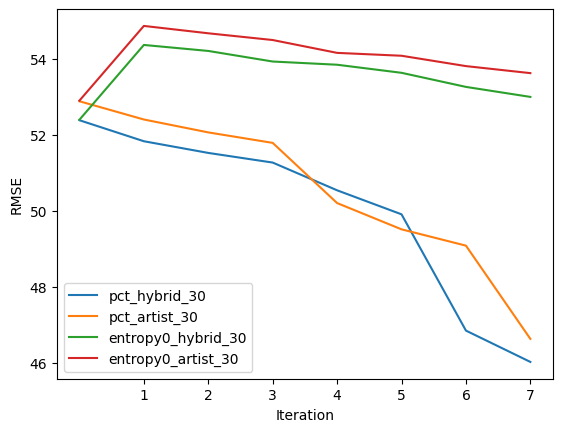

In [78]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_30_hybrid)), pct_30_hybrid, label='pct_hybrid_30')
ax1.plot(np.arange(len(pct_30_artist)), pct_30_artist, label='pct_artist_30')
ax1.plot(np.arange(len(entropy_30_hybrid)), entropy_30_hybrid, label='entropy0_hybrid_30')
ax1.plot(np.arange(len(entropy_30_artist)), entropy_30_artist, label='entropy0_artist_30')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=3)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 8)) 
plt.show()

## 40% warm

In [66]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.4)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [67]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_40 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_40 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

In [ ]:
entropy0_hybrid_40 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

In [ ]:
entropy0_artist_40 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

In [79]:
pct_40_hybrid = [52.5665, 51.2072,  49.7757, 49.1967, 48.5019, 48.0352, 47.3726, 46.9158]
pct_40_artist = [52.8862, 51.5470, 50.8641, 50.4838, 50.1626, 49.8014, 49.3805, 48.7934]
entropy0_40_hybrid = [52.5594, 54.3153, 54.1340, 53.2387, 53.0119, 52.9425, 52.7320, 52.6844]
entropy0_40_artist = [52.8911, 54.7381, 54.4716, 54.2356, 53.6274, 53.4382, 53.3805, 53.0868]

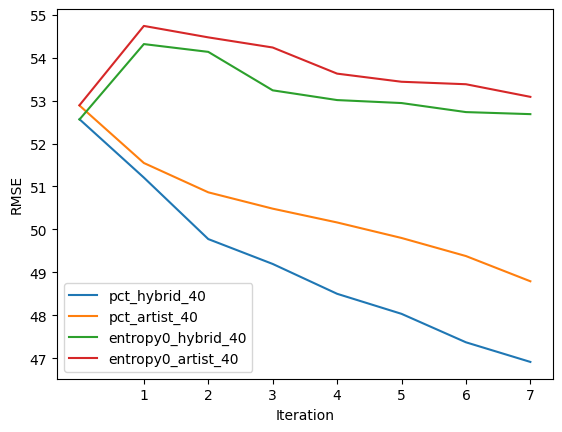

In [80]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_40_hybrid)), pct_40_hybrid, label='pct_hybrid_40')
ax1.plot(np.arange(len(pct_40_artist)), pct_40_artist, label='pct_artist_40')
ax1.plot(np.arange(len(entropy0_40_hybrid)), entropy0_40_hybrid, label='entropy0_hybrid_40')
ax1.plot(np.arange(len(entropy0_40_artist)), entropy0_40_artist, label='entropy0_artist_40')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=3)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 8)) 
plt.show()

## 50% warm

In [81]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.5)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [82]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [117]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_50 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.3068
MAE:  44.1017
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.3111
MAE:  44.1187
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.3020
MAE:  43.0687
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.4085
MAE:  41.1277
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 48.7688
MAE:  40.466

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 47.6160
MAE:  39.2737
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.7884
MAE:  38.4216
✅ Iteration 7 complete.


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_50 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

In [83]:
entropy0_hybrid_50 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 53.1623
MAE:  44.8608
RMSE: 56.8832
MAE:  51.3681
1
RMSE: 56.5990
MAE:  51.0424
2
RMSE: 56.4609
MAE:  50.9067
3
RMSE: 56.3258
MAE:  50.7478
4
RMSE: 56.2670
MAE:  50.6633
5
RMSE: 55.9919
MAE:  50.3858
6
RMSE: 55.7650
MAE:  50.1378
7


In [84]:
entropy0_artist_50 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.2818
MAE:  44.0860
RMSE: 55.8315
MAE:  50.2394
1
RMSE: 55.5128
MAE:  49.8857
2
RMSE: 55.4101
MAE:  49.7649
3
RMSE: 55.2377
MAE:  49.6091
4
RMSE: 55.1629
MAE:  49.5166
5
RMSE: 54.9381
MAE:  49.2649
6
RMSE: 54.5802
MAE:  48.8645
7


In [85]:
pct_50_hybrid = [52.5876, 52.3628, 52.0987, 50.2659, 48.5152, 47.1377, 46.4110, 45.2953]
pct_50_artist = [52.3068, 52.3111, 51.3020, 49.4085, 48.7688, 48.0867, 47.6160, 46.7884]

entropy0_50_hybrid = [53.1623, 56.8832, 56.5990, 56.4609, 56.3258, 56.2670, 55.9919, 55.7650]
entropy0_50_artist = [52.2818, 55.8315, 55.5128, 55.4101, 55.2377, 55.1629, 54.9381, 54.5802]

                      

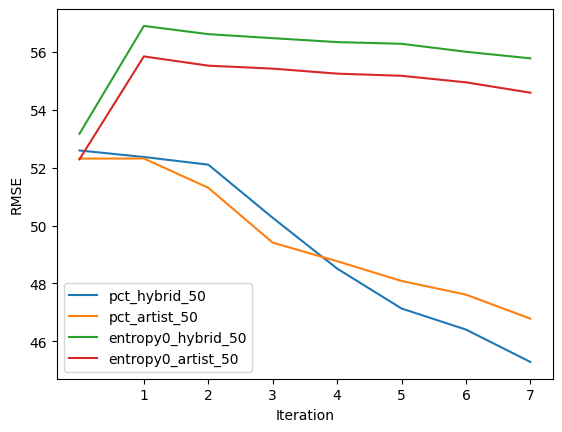

In [87]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_50_hybrid)), pct_50_hybrid, label='pct_hybrid_50')
ax1.plot(np.arange(len(pct_50_artist)), pct_50_artist, label='pct_artist_50')
ax1.plot(np.arange(len(entropy0_50_hybrid)), entropy0_50_hybrid, label='entropy0_hybrid_50')
ax1.plot(np.arange(len(entropy0_50_artist)), entropy0_50_artist, label='entropy0_artist_50')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=3)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 8)) 
plt.show()

### all entropy 

In [155]:
entropy0_hybrid_40 = [52.5594, 54.3153, 54.1340, 53.2387, 53.0119, 52.9425, 52.7320, 52.6844
]
entropy0_artist_40 = [52.8911, 54.7381, 54.4716, 54.2356, 53.6274, 53.4382, 53.3805, 53.0868
]

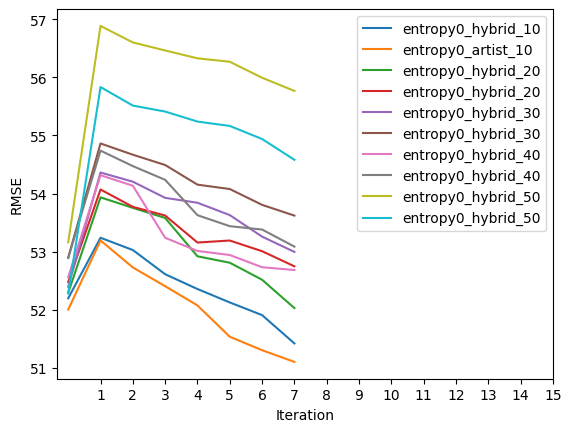

In [89]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(entropy_10_hybrid)), entropy_10_hybrid, label='entropy0_hybrid_10')
ax1.plot(np.arange(len(entropy_10_artist)), entropy_10_artist, label='entropy0_artist_10')
ax1.plot(np.arange(len(entropy_20_hybrid)), entropy_20_hybrid, label='entropy0_hybrid_20')
ax1.plot(np.arange(len(entropy_20_artist)), entropy_20_artist, label='entropy0_hybrid_20')
ax1.plot(np.arange(len(entropy_30_hybrid)), entropy_30_hybrid, label='entropy0_hybrid_30')
ax1.plot(np.arange(len(entropy_30_artist)),entropy_30_artist, label='entropy0_hybrid_30')
ax1.plot(np.arange(len(entropy0_40_hybrid)), entropy0_40_hybrid, label='entropy0_hybrid_40')
ax1.plot(np.arange(len(entropy0_40_artist)), entropy0_40_artist, label='entropy0_hybrid_40')
ax1.plot(np.arange(len(entropy0_50_hybrid)), entropy0_50_hybrid, label='entropy0_hybrid_50')
ax1.plot(np.arange(len(entropy0_50_artist)), entropy0_50_artist, label='entropy0_hybrid_50')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

### all pct

In [100]:
pct_10_artist = [51.9847, 52.0196, 47.9907, 46.1414, 44.8582, 44.2371, 43.2880, 42.4831]
pct_10_hybrid = [51.9772, 48.9743, 46.1831, 44.9121, 43.9624, 43.3400, 42.2745, 41.6559]

pct_20_hybrid = [52.3038, 52.2151, 51.6686, 51.3286, 51.0871, 50.8802, 50.6053, 49.9057]
pct_20_artist = [52.2930, 52.2144, 51.6760, 51.4298, 51.1970, 50.9571, 50.7175, 50.1466]

pct_30_artist = [52.8811, 52.4017, 52.0626, 51.7871, 50.2051, 49.5147, 49.0861, 46.6354]
pct_30_hybrid = [52.3823, 51.8302, 51.5232, 51.2696, 50.5404, 49.9093, 46.8529, 46.0297]

pct_40_hybrid = [52.5665, 51.2072,  49.7757, 49.1967, 48.5019, 48.0352, 47.3726, 46.9158]
pct_40_artist = [52.8862, 51.5470, 50.8641, 50.4838, 50.1626, 49.8014, 49.3805, 48.7934]

pct_50_hybrid = [52.5876, 52.3628, 52.0987, 50.2659, 48.5152, 47.1377, 46.4110, 45.2953]
pct_50_artist = [52.3068, 52.3111, 51.3020, 49.4085, 48.7688, 48.0867, 47.6160, 46.7884]



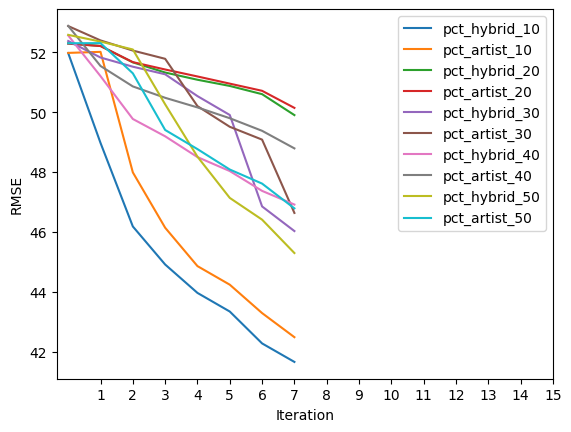

In [160]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_10[0])), pct_hybrid_10[0], label='pct_hybrid_10')
ax1.plot(np.arange(len(pct_artist_10_new[0])), pct_artist_10_new[0], label='pct_artist_10')
ax1.plot(np.arange(len(pct_hybrid_20[0])), pct_hybrid_20[0], label='pct_hybrid_20')
ax1.plot(np.arange(len(pct_artist_20[0])), pct_artist_20[0], label='pct_artist_20')
ax1.plot(np.arange(len(pct_hybrid_30[0])), pct_hybrid_30[0], label='pct_hybrid_30')
ax1.plot(np.arange(len(pct_artist_30[0])), pct_artist_30[0], label='pct_artist_30')
ax1.plot(np.arange(len(pct_hybrid_40)), pct_hybrid_40, label='pct_hybrid_40')
ax1.plot(np.arange(len(pct_artist_40)), pct_artist_40, label='pct_artist_40')
ax1.plot(np.arange(len(pct_hybrid_50)), pct_hybrid_50, label='pct_hybrid_50')
ax1.plot(np.arange(len(pct_artist_50[0])), pct_artist_50[0], label='pct_artist_50')


plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

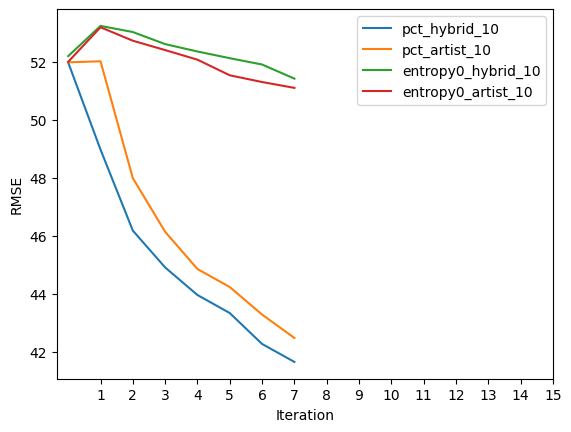

In [102]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_10_hybrid)), pct_10_hybrid, label='pct_hybrid_10')
ax1.plot(np.arange(len(pct_10_artist)), pct_10_artist, label='pct_artist_10')
ax1.plot(np.arange(len(entropy_10_hybrid)), entropy_10_hybrid, label='entropy0_hybrid_10')
ax1.plot(np.arange(len(entropy_10_artist)), entropy_10_artist, label='entropy0_artist_10')



plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()